In [1]:
!pip install pandas numpy matplotlib --quiet


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from azureml.core import Workspace, Dataset
ws = Workspace.from_config()
df = ws.datasets['synthetic_surgical_risk_data'].to_pandas_dataframe()

df.head()

{'infer_column_types': 'False', 'activity': 'to_pandas_dataframe'}
{'infer_column_types': 'False', 'activity': 'to_pandas_dataframe', 'activityApp': 'TabularDataset'}


Class DeploymentTemplateOperations: This is an experimental class, and may change at any time. Please see https://aka.ms/azuremlexperimental for more information.
/anaconda/envs/azureml_py310_sdkv2/lib/python3.10/site-packages/mlflow/__init__.py:41: UserWarning: Versions of mlflow (3.8.1) and child packages mlflow-skinny (3.5.0) are different. This may lead to unexpected behavior. Please install the same version of all MLflow packages.
  mlflow.mismatch._check_version_mismatch()
Overriding of current TracerProvider is not allowed
Overriding of current LoggerProvider is not allowed
Overriding of current MeterProvider is not allowed
Attempting to instrument while already instrumented
Attempting to instrument while already instrumented
Attempting to instrument while already instrumented
Attempting to instrument while already instrumented
Attempting to instrument while already instrumented


patient_id  age   bmi  blood_pressure_systolic  cholesterol  has_diabetes  \
0           1   69  26.6                      105          198             0   
1           2   32  20.3                      139          243             1   
2           3   89  35.2                      111          173             0   
3           4   78  30.5                      152          297             0   
4           5   38  27.6                      170          186             0   

   has_hypertension  prior_surgeries  asa_score  high_risk_label  
0                 0                0          2                1  
1                 1                1          3                0  
2                 0                2          3                0  
3                 1                1          3                0  
4                 0                4          2                0

In [3]:
df.shape

(500, 10)

In [4]:
#Analyze the Target Variable
print("🎯 TARGET VARIABLE ANALYSIS")
print("Distribution of high_risk_label:")
print(df['high_risk_label'].value_counts())


🎯 TARGET VARIABLE ANALYSIS
Distribution of high_risk_label:
0    412
1     88
Name: high_risk_label, dtype: int64


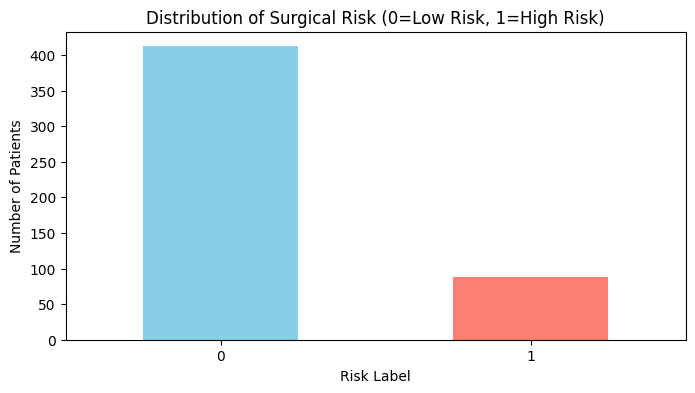

In [5]:
# Visualize the distribution
plt.figure(figsize=(8, 4))
df['high_risk_label'].value_counts().plot(kind='bar', color=['skyblue', 'salmon'])
plt.title('Distribution of Surgical Risk (0=Low Risk, 1=High Risk)')
plt.xlabel('Risk Label')
plt.ylabel('Number of Patients')
plt.xticks(rotation=0)
plt.show()

In [6]:
# Calculate percentages
low_risk_pct = (df['high_risk_label'].value_counts()[0] / len(df)) * 100
high_risk_pct = (df['high_risk_label'].value_counts()[1] / len(df)) * 100
print(f"\n📈 Low Risk Patients: {low_risk_pct:.1f}%")
print(f"📈 High Risk Patients: {high_risk_pct:.1f}%")


📈 Low Risk Patients: 82.4%
📈 High Risk Patients: 17.6%


In [7]:
# Check how each feature correlates with surgical risk
print("🔗 CORRELATION WITH SURGICAL RISK")
# Calculate correlation for numeric features
numeric_cols = ['age', 'bmi', 'blood_pressure_systolic', 'cholesterol', 'prior_surgeries']
correlations = df[numeric_cols + ['high_risk_label']].corr()['high_risk_label'].sort_values(ascending=False)

print("Correlation of features with high_risk_label:")
for feature, corr in correlations.items():
    if feature != 'high_risk_label':
        print(f"  {feature}: {corr:.3f}")

🔗 CORRELATION WITH SURGICAL RISK
Correlation of features with high_risk_label:
  bmi: 0.057
  cholesterol: 0.018
  blood_pressure_systolic: -0.000
  prior_surgeries: -0.013
  age: -0.066


In [8]:
# 🔧 FEATURE ENGINEERING: Create new, more predictive features
print("\n🔧 CREATING NEW FEATURES")

# 1. Age categories (different risk profiles by age group)
df['age_group'] = pd.cut(df['age'], 
                         bins=[18, 40, 60, 90], 
                         labels=['young', 'middle', 'senior'])

# 2. Combined comorbidity score (diabetes + hypertension)
df['comorbidity_score'] = df['has_diabetes'] + df['has_hypertension']

# 3. Blood pressure category
df['bp_category'] = pd.cut(df['blood_pressure_systolic'],
                           bins=[0, 120, 140, 180, 300],
                           labels=['normal', 'elevated', 'high', 'crisis'])

# 4. BMI categories (medical standard)
df['bmi_category'] = pd.cut(df['bmi'],
                            bins=[0, 18.5, 25, 30, 100],
                            labels=['underweight', 'normal', 'overweight', 'obese'])

print("✅ New features created:")
print(f"  1. age_group: {df['age_group'].unique().tolist()}")
print(f"  2. comorbidity_score: range {df['comorbidity_score'].min()} to {df['comorbidity_score'].max()}")
print(f"  3. bp_category: {df['bp_category'].unique().tolist()}")
print(f"  4. bmi_category: {df['bmi_category'].unique().tolist()}")

print("\n📊 Sample with new features:")
print(df[['age', 'age_group', 'has_diabetes', 'has_hypertension', 'comorbidity_score', 
          'blood_pressure_systolic', 'bp_category', 'bmi', 'bmi_category']].head())


🔧 CREATING NEW FEATURES
✅ New features created:
  1. age_group: ['senior', 'young', 'middle', nan]
  2. comorbidity_score: range 0 to 2
  3. bp_category: ['normal', 'elevated', 'high']
  4. bmi_category: ['overweight', 'normal', 'obese']

📊 Sample with new features:
   age age_group  has_diabetes  has_hypertension  comorbidity_score  \
0   69    senior             0                 0                  0   
1   32     young             1                 1                  2   
2   89    senior             0                 0                  0   
3   78    senior             0                 1                  1   
4   38     young             0                 0                  0   

   blood_pressure_systolic bp_category   bmi bmi_category  
0                      105      normal  26.6   overweight  
1                      139    elevated  20.3       normal  
2                      111      normal  35.2        obese  
3                      152        high  30.5        obese  
4    